In [6]:
#-------import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]='4,5'
os.environ["CUDA_DEVICE_MAX_CONNECTIONS"]='32'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, activations
from tensorflow.keras.models import Model


import os.path
#from keras.backend.tensorflow_backend import set_session
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
from scipy.io import loadmat
from keras.layers import Input, Conv2D,Conv1D, Lambda, merge, Dense, Flatten,MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import time
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import imp

In [7]:
#Load data


In [20]:
#Load and read data
import scipy.io as read
import numpy as np
case1 = read.loadmat('Data/case1.mat')
case2 = read.loadmat('Data/case2.mat')
case3 = read.loadmat('Data/case3.mat')
case4 = read.loadmat('Data/case4.mat')
#get total data
data1=case1['case1']
data2=case2['case2']
data3=case3['case3']
data4=case4['case4']
#load all data and label data
data = []
labels = []
for i in range(int(data1.shape[3])):
    data.append(data1[:,:,:,i])
    labels.append(0)

for j in range(int(data2.shape[3])):
    data.append(data2[:,:,:,j])
    labels.append(1)
for k in range(int(data3.shape[3])):
    data.append(data3[:,:,:,k])
    labels.append(2)
for m in range(int(data4.shape[3])):
    data.append(data4[:,:,:,m])
    labels.append(3)

In [21]:
data = np.array(data)
labels = np.array(labels)

In [22]:
#Sprit data
from sklearn.model_selection import train_test_split

X_train_raw1, X_test, y_train_raw1, y_test = train_test_split(data, labels, 
                                                    test_size = 0.2,
                                                    stratify = labels,   #Make train and test set have same distribution
                                                   )
#print(X_train_raw1.shape, X_test.shape, y_train_raw1.shape, y_test.shape)


In [23]:
from sklearn.model_selection import train_test_split

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_train_raw1, y_train_raw1, 
                                                    test_size = 0.2,
                                                    stratify = y_train_raw1,   #Make train and test set have same distribution
                                                   )
#print(X_train_raw.shape, X_val_raw.shape, y_train_raw.shape, y_val_raw.shape)

In [24]:
#Model 
def load_siamese_net(input_shape = (40, 30, 1)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    convnet = Sequential()
    convnet.add(Conv2D(filters=16, kernel_size=(2,2), strides=1, padding='same', activation='relu', input_shape=(40,30,1), name='conv2d_1'))
    convnet.add(BatchNormalization())
    convnet.add(Dropout(0.3))
    convnet.add(Conv2D(filters=32, kernel_size=(5,5), strides=2, padding='same', activation='relu', name='conv2d_2'))
    convnet.add(BatchNormalization())
    convnet.add(Dropout(0.3))
    convnet.add(Conv2D(filters=64, kernel_size=(5,5), strides=1, padding='same', activation='relu', name='conv2d_3'))
    convnet.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_4'))
    convnet.add(BatchNormalization())
    convnet.add(Dropout(0.3))
    convnet.add(Flatten(name='Flatten_1'))
    convnet.add(Dense(64, activation='relu', name='Dense_1'))
    convnet.add(Dense(32, activation='relu', name='Dense_2'))

    #call the convnet Sequential model on each of the input tensors so params will be shared
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    #layer to merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    #call this layer on list of two input tensors.
    L1_distance = L1_layer([encoded_l, encoded_r])
    D1_layer = Dropout(0.5)(L1_distance)
    prediction = Dense(1,activation='sigmoid')(D1_layer)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # optimizer = Adam(0.00006)
    optimizer = Adam()
    #//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
    siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)
    
    return siamese_net

In [25]:
siamese_net = load_siamese_net()
print('\nsiamese_net summary:')
siamese_net.summary()


siamese_net summary:
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 40, 30, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           2598480     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.metrics import classification_report_imbalanced
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def confusion_plot(pred, y_true):
    sns.set(rc={'figure.figsize':(5,4)})
    fault_labels = np.unique(y_true)
    print(fault_labels)
    cm_array = confusion_matrix(y_true, pred,labels=fault_labels)
    df_cm = pd.DataFrame(cm_array, index = fault_labels,
                      columns = fault_labels)
    sns.heatmap(df_cm,annot=True)
    plt.show()
    
    print(classification_report_imbalanced(np.array(y_true), np.array(pred)))
    return plt
    
def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    mpl.rcParams.update(mpl.rcParamsDefault)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
    plt.figure(figsize=(4, 4)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(list(range(cm.shape[0]))))
#     plt.xticks(tick_marks, classes, rotation=45)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes,rotation=90)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt
def plot_with_labels(data):
    #loop through labels and plot each cluster
    sns.set(rc={'figure.figsize':(5,5)})
    plt.figure()
    for i, label in enumerate(range(10)):

        #add data points 
        plt.scatter(x=data.loc[data['label']==label, 'x'], 
                    y=data.loc[data['label']==label,'y'], 
                    color=cm.rainbow(int(255 * i / 9)), 
                    alpha=0.20)

        #add label
        plt.annotate(label, 
                     data.loc[data['label']==label,['x','y']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=14,
                     weight='bold',
                     color='black') 

In [33]:
import keras
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping

import siamese
imp.reload(siamese)
import utils
imp.reload(utils)

snrs = [None]


settings = {
  "N_way": 4,           # how many classes for testing one-shot tasks>
  "batch_size": 64,
  "best": -1,
  "evaluate_every": 200,   # interval for evaluating on one-shot tasks
  "loss_every": 40,      # interval for printing loss (iterations)
  "n_iter": 10000,
  "n_val": 2,          #how many one-shot tasks to validate on?
  "n": 0,
  "save_path":"",
  "save_weights_file": "weights-best-10-oneshot-low-data.hdf5",
#"save_weights_cnn": "weights-best-10-cnn-low-data.hdf5"
}

exp_name = "EXP-73"
# exps = [60,90,120,200,300,600,900,1500,3200]
# exps = [90,200,600,1500,3200]
exps = [4384]
times = 1

In [34]:
import os,re
import errno
import random
import urllib.request as urllib
import numpy as np
from scipy.io import loadmat
from sklearn.utils import shuffle
def _mkdir(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            print("can't create directory '{}''".format(path))
            exit(1)

In [35]:
is_training = True   # enable or disable train models. if enable training, save best models will be update.
import cwru 
def EXPAB_train_and_test(exp_name,exps,is_training):
    train_classes = sorted(list(set(y_train_raw)))
    train_indices = [np.where(y_train_raw == i)[0] for i in train_classes]
    for exp in exps:
        scores_1_shot = []
        num = int(exp/len(train_classes))
        settings['evaluate_every'] = 200 if exp<1000 else 600
        print(settings['evaluate_every'])
        for time_idx in range(times):
            seed = int(time_idx/4)*10
            np.random.seed(seed)
            print('random seed:',seed)
            print("\n%s-%s"%(exp,time_idx) + '*'*80)
            settings["save_path"] = "tmp/%s/size_%s/time_%s/" % (exp_name,exp,time_idx)
            _mkdir(settings["save_path"])
            X_train = X_train_raw
            y_train = y_train_raw
            X_val = X_val_raw
            y_val = y_val_raw
            print(X_train.shape, y_train.shape,X_val.shape, y_val.shape)

            # load one-shot model and training
            siamese_net = load_siamese_net()
            siamese_loader = siamese.Siamese_Loader(X_train,
                                            y_train,
                                            X_val,
                                            y_val)

            if(is_training):
                print(siamese.train_and_test_oneshot(settings,siamese_net,siamese_loader))        
            # load wdcnn model and training
            y_train = keras.utils.to_categorical(y_train, len(train_classes))
            y_val = keras.utils.to_categorical(y_val, len(train_classes))
            y_test_onehot = keras.utils.to_categorical(y_test, len(train_classes))
            print("load best weights",settings["save_path"] + settings['save_weights_file'])
            siamese_net.load_weights(settings["save_path"] + settings['save_weights_file'])
            for snr in snrs:
                print("\n%s_%s_%s"%(exp,time_idx,snr) + '*'*80)
                X_test_noise = []
                if snr != None:
                    for x in X_test:
                        X_test_noise.append(utils.noise_rw(x,snr))
                    X_test_noise = np.array(X_test_noise)
                else:
                    X_test_noise = X_test
                # test 1_shot and 5_shot
                siamese_loader.set_val(X_test_noise,y_test)
                s = 'val'
               ##  prods_5_shot = []
                scores = []
                for k in range(5):
                    val_acc,preds, prods = siamese_loader.test_oneshot2(siamese_net,len(siamese_loader.classes[s]),
                                                                 len(siamese_loader.data[s]),verbose=False)
    #                 utils.confusion_plot(preds[:,1],preds[:,0])
                    print(val_acc,preds.shape, prods.shape)
                    scores.append(val_acc)

                scores_1_shot.append(scores[0])

        a =pd.DataFrame(np.array(scores_1_shot).reshape(-1,len(snrs)))
        a.columns = snrs
        a.to_csv("tmp/%s/size_%s/scores_1_shot.csv" % (exp_name,exp),index=True)
        
EXPAB_train_and_test(exp_name,exps,is_training)

600
random seed: 0

4384-0********************************************************************************
(3507, 40, 30, 1) (3507,) (877, 40, 30, 1) (877,)
{'train': [0, 1, 2, 3], 'val': [0, 1, 2, 3]}
3507 877
[893, 862, 881, 871] [223, 215, 221, 218]
{'N_way': 4, 'batch_size': 64, 'best': -1, 'evaluate_every': 600, 'loss_every': 40, 'n_iter': 10000, 'n_val': 2, 'n': 0, 'save_path': 'tmp/EXP-73/size_4384/time_0/', 'save_weights_file': 'weights-best-10-oneshot-low-data.hdf5'}
training...

iteration 0 evaluating: 50.0
560 : 0.38574,
iteration 600 evaluating: 100.0
1160 : 0.24236,
iteration 1200 evaluating: 100.0
1760 : 0.18306,
iteration 1800 evaluating: 100.0
2360 : 0.18802,
iteration 2400 evaluating: 100.0
2960 : 0.10929,
iteration 3000 evaluating: 100.0
3560 : 0.17373,
iteration 3600 evaluating: 100.0
4160 : 0.15924,
iteration 4200 evaluating: 100.0
4760 : 0.03493,
iteration 4800 evaluating: 100.0
5360 : 0.13659,
iteration 5400 evaluating: 100.0
5960 : 0.17009,
iteration 6000 evaluat

In [36]:
def EXPAB_analysis(exp_name,exps):
    scores_1_shot_all = pd.DataFrame()
    scores_5_shot_all = pd.DataFrame()
    scores_5_shot_prod_all = pd.DataFrame()
    scores_wdcnn_all = pd.DataFrame()
    for exp in exps:
        file_path = "tmp/%s/size_%s" % (exp_name,exp)
        tmp_data = pd.read_csv("%s/scores_1_shot.csv" % (file_path), 
                               sep=',', index_col=0)
        tmp_data['exp'] = exp 
        scores_1_shot_all = pd.concat([scores_1_shot_all,tmp_data],axis=0)

        tmp_data = pd.read_csv("%s/scores_5_shot.csv" % (file_path), 
                               sep=',', index_col=0)
        tmp_data['exp'] = exp 
        scores_5_shot_all = pd.concat([scores_5_shot_all,tmp_data],axis=0)

        tmp_data = pd.read_csv("%s/scores_5_shot_prod.csv" % (file_path), 
                               sep=',', index_col=0)
        tmp_data['exp'] = exp 
        scores_5_shot_prod_all = pd.concat([scores_5_shot_prod_all,tmp_data],axis=0)
        
        tmp_data = pd.read_csv("%s/scores_wdcnn.csv" % (file_path), 
                               sep=',', index_col=0)
        tmp_data['exp'] = exp 
        scores_wdcnn_all = pd.concat([scores_wdcnn_all,tmp_data],axis=0)


    scores_1_shot_all.to_csv("tmp/%s/scores_1_shot_all.csv" % (exp_name), float_format='%.6f', index=True)
   

    scores_1_shot_all['model'] = 'One-shot'

    scores_all = pd.concat([scores_1_shot_all],axis=0)
    scores_all.to_csv("tmp/%s/scores_all.csv" % (exp_name), float_format='%.6f', index=True)   
    return scores_all

In [39]:
from sklearn.metrics import accuracy_score
import keras
dir_list = ('case1','case2', 'case3','case4')

X_train = X_train_raw
y_train = y_train_raw
X_val = X_val_raw
y_val = y_val_raw

siamese_loader = siamese.Siamese_Loader(X_train,
                                y_train,
                                X_test,
                                y_test)

siamese_net = load_siamese_net()
settings["save_path"] = "tmp/%s/size_%s/time_%s/" % (exp_name,4384,0)
siamese_net.load_weights(settings["save_path"] + settings['save_weights_file'])
#wdcnn_net.load_weights("%s/weights-best-10-cnn-low-data.hdf5" % (settings["save_path"]))
y_test_onehot = keras.utils.to_categorical(y_test, len(dir_list))  

{'train': [0, 1, 2, 3], 'val': [0, 1, 2, 3]}
3507 1097
[893, 862, 881, 871] [279, 269, 276, 273]


In [57]:
folder_name_mod = ['case1','case2','case3','case4']
marker_list = ['*', 'p', 'P', '^']
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
def plot_with_labels(data):
    
    plt.figure()
    for i, label in enumerate(range(4)):
            plt.scatter(x=data.loc[data['label']==label, 'x'], 
                        y=data.loc[data['label']==label,'y'], 
                        facecolors="none", edgecolors=color[i], 
                        marker = marker_list[i], s=100 )
            plt.annotate(label, 
                     data.loc[data['label']==label,['x','y']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=14)
                    # weight='bold',
                     #color='black') 
    plt.legend(folder_name_mod, fontsize=15)
    plt.tick_params(labelsize=15)
    plt.grid(linestyle='--')

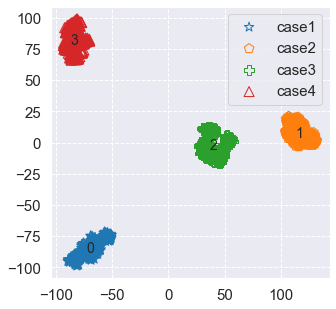

In [58]:
#visualize data 
from keras import backend as K
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')

intermediate_tensor_function = K.function([siamese_net.layers[2].layers[0].input],
                                          [siamese_net.layers[2].layers[-1].output])

plot_only = len(y_test)
intermediate_tensor = intermediate_tensor_function([X_test[0:plot_only]])[0]
# Visualization of trained flatten layer (T-SNE)
tsne = TSNE(n_components=2, init='pca', random_state=0)
low_dim_embs = tsne.fit_transform(intermediate_tensor)
p_data = pd.DataFrame(columns=['x', 'y', 'label'])
p_data.x = low_dim_embs[:, 0]
p_data.y = low_dim_embs[:, 1]
p_data.label = y_test[0:plot_only]
plot_with_labels(p_data)
plt.savefig("%s/4384-tsne-one-shot5.pdf" % (settings["save_path"]))


In [68]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.metrics import classification_report_imbalanced
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

    
def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    mpl.rcParams.update(mpl.rcParamsDefault)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
    plt.figure(figsize=(4, 4)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.73)
    tick_marks = np.arange(len(list(range(cm.shape[0]))))
#     plt.xticks(tick_marks, classes, rotation=45)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes,rotation=45)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt


Normalized confusion matrix
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


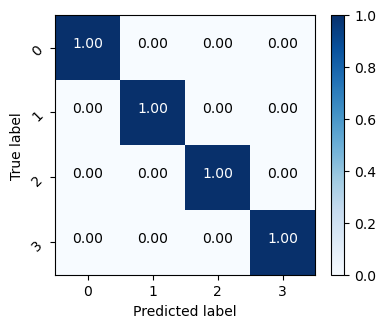

In [69]:
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
s = 'val'
val_acc,preds, prods = siamese_loader.test_oneshot2(siamese_net,len(siamese_loader.classes[s]),len(siamese_loader.data[s]),verbose=False)
# utils.confusion_plot(preds[:,1],preds[:,0])
plot_confusion_matrix(confusion_matrix(y_test,preds[:,1]),  normalize=True,  title=None)
plt.savefig("%s/4384-cm-one-shot3.pdf" % (settings["save_path"]))